In [1]:
# for setting up the data
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt

# for pre-processing and evaluation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

# for numerical computations
import tensorflow as tf
from tensorflow.python.framework import ops

In [2]:
# import the dataset
bank_marketing_dataset = pd.read_csv("dataset/bank-full.csv", sep=';')

In [3]:
# overview of the data
bank_marketing_dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
# use selected columns as feature columns
x = bank_marketing_dataset.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 12, 13, 14, 15]]
y = bank_marketing_dataset['y'].values

In [5]:
# one hot encode the categorical variables
x = pd.get_dummies(x, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 
                            'campaign', 'pdays', 'previous', 'poutcome'], drop_first=True).values

In [6]:
# encode the output variable into 1's & 0's
label_encoder_y = LabelEncoder()

# fir the encoder to Y and transform it
y = label_encoder_y.fit_transform(y)

# reshape y to a rank 2 tensor from a rank 1
y = y.reshape(y.shape[0], 1)

In [7]:
# normalize the inputs for faster training time
feature_scaler = MinMaxScaler(feature_range=(0,1))
x = feature_scaler.fit_transform(x)

/anaconda/envs/deep-learning/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
# split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)

In [9]:
# reshape X and Y into array of (n_x, m)
X_train = X_train.T
y_train = y_train.T

X_test = X_test.T
y_test = y_test.T

In [10]:
print("Features in X: " + str(X_train.shape[0]))
print("Number of Outputs (Y): " + str(y_train.shape[0]))
print("Training examples: " + str(X_train.shape[1]))
print("Test examples: " + str(X_test.shape[1]))

Features in X: 669
Number of Outputs (Y): 1
Training examples: 40689
Test examples: 4522


In [11]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, number of features
    n_y -- scalar, number of output classes
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    """
    X = tf.placeholder(shape=[n_x, None], dtype=tf.float32)
    Y = tf.placeholder(shape=[n_y, None], dtype=tf.float32)
    
    return X, Y

In [12]:
def initialize_params(layer_dimensions):
    """
    Creates a python dicitonary that contains the weights & bias for the hidden layers
    
    Arguments:
    layer_dimensions -- integer array, consisting of values representing number of nodes in each layer
    
    Returns:
    parameters -- python dictionary consisting of weights and bias parameters for each hidden layer
    """
    
    number_of_layers = len(layer_dimensions)
    parameters = {}
    
    for layer in range(1, number_of_layers):
        param_key_weight = "W" + str(layer)
        param_key_bias = "b" + str(layer)
        
        parameters[param_key_weight] = tf.get_variable(name=param_key_weight, 
                                                       shape=[layer_dimensions[layer], layer_dimensions[(layer - 1)]], 
                                                       initializer=tf.contrib.layers.xavier_initializer())
        parameters[param_key_bias] = tf.get_variable(name=param_key_bias, 
                                                     shape=[layer_dimensions[layer], 1], 
                                                     initializer=tf.zeros_initializer())
        
    return parameters

In [13]:
def forward_propagation(X, parameters, dropout=False):
    """
    Implements the forward propagation for the model: (LINEAR -> RELU) x L -> LINEAR -> SIGMOID
    
    Arguments:
    X -- input dataset placeholder, of shape (number of features, number of examples)
    parameters -- python dictionary containing weights and bias parameters
    dropout -- boolean, set to True to implement dropout

    Returns:
    Z_output -- the output of the last LINEAR unit 
    """
    
    L = len(parameters) // 2 # the number of layers not including the input
    A = X
    
    for layer in range(1, (L)):
        Z = tf.matmul(parameters["W" + str(layer)], A) + tf.cast(parameters["b" + str(layer)], dtype=tf.float32)
        A = tf.nn.relu(Z)
        if dropout == True:
            A = tf.nn.dropout(A, keep_prob=0.8)
        
    Z_output = tf.matmul(parameters["W" + str(L)], A) + tf.cast(parameters["b" + str(L)], dtype=tf.float32)
    
    return Z_output

In [14]:
def compute_cost(Z_final, Y, parameters, loss_type='reglr', batch_size=1, lambd=0.001):
    """
    Computes the cost
    
    Arguments:
    Z_final -- output of forward propagation (output of the last LINEAR unit)
    Y -- "true" labels vector placeholder, same shape as Z_final
    parameters -- python dictionary containing weights and bias parameters
    loss_type -- string, use 'l2' for l2 regularization
    batch_size -- batch size
    lambd -- lambda parameter which will be used for l2 loss
    
    Returns:
    cost - Tensor of the cost function
    """
    
    logits = tf.transpose(Z_final)
    labels = tf.transpose(Y)
    
    if loss_type == 'reglr':
        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
    
    elif loss_type == 'l2':
        L = len(parameters) // 2 # the number of layers not including input
        l2_loss = 0
        
        for layer in range(1, L):
            l2_loss += tf.nn.l2_loss(parameters["W" + str(layer)])
            
        l2_loss = (1 / batch_size) * lambd * l2_loss
        sigmoid_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
        cost = l2_loss + sigmoid_loss
    
    return cost

In [15]:
def model(X_train, Y_train, X_test, Y_test, layer_dimensions, learning_rate=0.01, num_epochs=1500, 
          loss_type='reglr', dropout=False, print_cost=True):
    """
    Implements a L-layer tensorflow neural network: (LINEAR->RELU) xL ->LINEAR->SIGMOID.
    
    Arguments:
    X_train -- training set, of shape (number of features, number of training examples)
    Y_train -- test set, of shape (output size = 1, number of training examples)
    X_test -- training set, of shape (number of features, number of training examples)
    Y_test -- test set, of shape (output size = 1, number of test examples)
    layer_dimensions -- dimensions, numer of units in each layer of the network
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    loss_type -- string, use 'l2' for l2 regularization
    dropout -- boolean, set True to implement dropout
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
    
    # Initialize parameters
    parameters = initialize_params(layer_dimensions)
    
    # Forward propagation
    Z_final = forward_propagation(X, parameters, dropout=dropout)
    
    # Compute cost
    cost = compute_cost(Z_final, Y, parameters, loss_type=loss_type, batch_size=m)
    
    # Back Propagation Update weights 
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    
    # Start session to compute tensorflow graph
    with tf.Session() as sess:
        
        # Initialization
        sess.run(init)
        
        # Training loop
        for epoch in range(num_epochs):
            
            epoch_cost = 0      # Defines a cost related to an epoch
            
            _ , batch_cost = sess.run([optimizer, cost], feed_dict={X: X_train, Y:Y_train})
            
            epoch_cost += batch_cost
            
            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z_final), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

In [16]:
def predict(X_test, parameters):
    """
    Returns predictions for a given set
    Arguments:
    X_test -- training set, of shape (number of features, number of training examples)
    parameters -- python dictionary containing weights and bias parameters
    
    Returns:
    y_pred -- numpy array that contains predictions for the X set
    """
    (n_x, m) = X_test.shape
    
    X = tf.placeholder(shape=[n_x, None], dtype=tf.float32)
    
    y_pred = forward_propagation(X=X, parameters=parameters)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        y_pred = sess.run(y_pred, feed_dict={X: X_test})
        
    return y_pred

Cost after epoch 0: 0.668406
Cost after epoch 100: 0.286475
Cost after epoch 200: 0.239635
Cost after epoch 300: 0.227813
Cost after epoch 400: 0.222171
Cost after epoch 500: 0.220234
Cost after epoch 600: 0.216283
Cost after epoch 700: 0.213449
Cost after epoch 800: 0.212512
Cost after epoch 900: 0.209926
Cost after epoch 1000: 0.208252
Cost after epoch 1100: 0.208036
Cost after epoch 1200: 0.205597
Cost after epoch 1300: 0.203775
Cost after epoch 1400: 0.202669


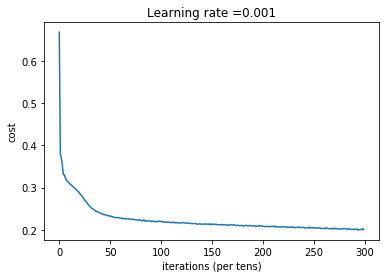

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 1.0


In [17]:
# Dimensions of the layer, change those numbers to increase nodes or 
#add another element between the 0th and the last element to add an extra layer
layer_dimensions = [669, 450, 335, 1]

parameters = model(X_train, y_train, X_test, y_test, layer_dimensions, 
                   learning_rate=0.001, num_epochs=1500, loss_type='reglr', dropout=True)

In [21]:
y_pred = predict(X_test, parameters)
y_pred = y_pred > 0.5

In [22]:
cm = confusion_matrix(y_test.T, y_pred[0].T) #will need to transpose the matrix as it compare them with the 0th element
print("Accuracy on test: %f" % ((cm[0][0] + cm[1][1]) / float(y_test.shape[1]) * 100))

Accuracy on test: 89.053516
